# This Notebook contains code to make  figures from the orginal dataset (no machine learning)

## Load MatLab File using SciPy

In [1]:
from nptdms import TdmsFile #For reading LabView files
import numpy as np                #for numerical operations*******************************************************
import pandas as pd               #for data reading/structure
import matplotlib.pyplot as plt          #Used for plotting
import scipy.signal as signal
from functools import partial
import multiprocessing
from contextlib import contextmanager
import sys
import bepy as be
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA, NMF, DictionaryLearning
import seaborn as sns
import matplotlib.gridspec as gridspec

import matplotlib.colors
from matplotlib.ticker import StrMethodFormatter

from sklearn.cluster import KMeans

from os.path import dirname, join as pjoin
import scipy.io as sio

### Load Data from Textfiles to a dataframe

In [2]:
####Load table from textfile

read=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\SHOcoefreadvec.txt',names=["Amp",'Res','Q','Phase'])
write=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\SHOcoefwritevec.txt',names=["Amp",'Res','Q','Phase'])

In [3]:
###Load Mat file to extract DC bias vector
mat_data = sio.loadmat('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\PZTbatch212BEPS_0003.mat',squeeze_me=True, struct_as_record=False)

dc=list(mat_data['dc_amp_vec_full']) ##### DC Bias Values 

In [4]:
num_acq=np.arange(0,900)    ######900 acqusisitions. Collection order is row ordered
acq=np.tile(num_acq,192)
len(acq)

cycle=np.arange(0,3) ########### Cycle number. First 900 acquistion is cycle1 for first DC value. Second 900 for cycle2
# for first DC values
cycle=np.repeat(cycle,900)
cycle=np.tile(cycle,64)
len(cycle)

dc=dc[0:64]        ######### DC Bias Values associated with a single cycle

In [5]:
def reshape_data(df):

#### Create inital index object for the Dataframe. Using .from_product() interate the index to reflect the organization
#of the raw data:The first 30 rows of the array correspond to the SHO coefficients for the first step of the first 
#loop and for the 30 x coordinates along the first y coordinate i.e. SHOcoef(:,1,1,1,1). Then the next 30 rows would 
#be the first step of the first loop for 30 x coordinates along the 2nd y coordinate i.e. SHOcoef(:,2,1,1,1).  
    x_cord=np.array(range(30))
    y_cord=np.array(range(30))
    chirps=np.array(range(192))
    parameters=[chirps,x_cord,y_cord,]  
    index=pd.MultiIndex.from_product(parameters, names=['chirps','y', 'x',])
    df=df.set_index(index)

##### Add Index and Reorganize such that aqusition pionts are along axis=0 (rows) and chirps are along axis=1 columns
    df=df.assign(cycle=cycle).set_index('cycle', append=True)  ####Add Cycle # label
    df=df.unstack(level=3).unstack(level=0).dropna(axis=1,how='all') ####Data Resort by Cycle Number and DC chirps. Original data 
##is grouped by DC step values: every 900 values is the response of every point for the first DC step and cycle. 
##The next 900 is all reponses to the first DC step in the next cycle. The data is ordered corecctly at this line but
## the chirp number labels now longer make sense


####Convert labels from XY coridinate pairs to acquisition numbers
    df=df.set_index(num_acq,)
    df.index.name='Acq#'  

###Create Dictionary to Map chirp labels Bias values. 
    chirp_keys=chirps
    chirp_values=np.repeat(dc,3)
    bias_dict = {chirp_keys[i]: chirp_values[i] for i in range(len(chirp_keys))}   ###Create Dictionary to Map chirp labels Bias values

#### Use dictionary to create new array for indexing
    order1=df.columns.get_level_values('chirps')
    bias=[]
    for i in order1:
        bias.append(bias_dict[i])
    bias=np.array(bias)

##### Get other label arrays from existing data frame. Cycles and Variable Labels were not effected by reordering 
    cycles=df.columns.get_level_values('cycle')
    var=df.columns.get_level_values(None)

### Create a new Multiindex for with relevent Variable, Cycle, Chirp Number, NAd DC bias labels
    col_index=pd.MultiIndex.from_arrays([var,cycles,np.tile(chirps,4),bias], names=['Variable','cycle#','chirp#', 'DC',])


### Put data into new Dataframe with accruate index and column information
    df=pd.DataFrame(df.values, index=df.index, columns=col_index)

#### Calculate PR response from SHO coefficients
    pr= pd.DataFrame(index=df.index,columns=df['Amp'].columns)
    pr=df['Amp']*np.sin(df['Phase'])

#### Add PR to Refit data frame
    df=pd.concat(dict(Amp = df['Amp'], Phase = df['Phase'], Res=df['Res']/1000, Q=df['Q'],PR=pr),axis=1)


###Adjust the phase to make phase lie between 0 and pi
    offset=-1.55
    df['Phase']=df['Phase']+np.abs(offset)
##Convert phase to degrees
    df['Phase']=df['Phase']*(180/np.pi)
    return df


In [6]:
def remove_q(df):
####### Map and Remove points the Data set with Q values larger than 500 and less than 0
    test = df['Q'].applymap(lambda x: np.nan if x< 0 else x)
    test = test.applymap(lambda x: np.nan if x> 500 or x == 500 else x)
    
 ######Make a copy of the input df   
    df_nan=df.copy()

#####
    for var in ['Amp','Phase',"PR",'Res','Q']:
        df_var=df[var].copy()                       ####Create a copy of the variable/parameter dataframe
        df_var[test.isnull()]=np.nan                ####Use test df as mask and assign variable dataframe nan value in same locations
        df_nan[var]=df_var                         ###Replace master dataframe value with masked value (includes nan)

    return df_nan

In [7]:
def impute_fill(df,mean,std):
########Define Bounds###########
    mean=mean ### use df_means
    std=std ### use df_devs
        
    upper=mean + (3*std)
    lower=mean - (3*std)
    print('Upper Limit: ', upper)
    print('Lower Limit: ', lower)

######Make a copy of the input df   
    df_fill=df.copy()

####### Map and Remove points the Data set with Q values larger than upper and less than lower
    test = df['Q'].applymap(lambda x: np.nan if x < lower else x)
    test = test.applymap(lambda x: np.nan if x > upper else x)

    for var in ['Amp','Phase',"PR",'Res','Q']:
        df_var=df[var].copy()                       ####Create a copy of the variable/parameter dataframe
        df_var[test.isnull()]=np.nan                ####Use test df as mask and assign variable dataframe nan value in same locations
        df_fill[var]=df_var                         ###Replace master dataframe value with masked value (includes nan)

        df_fill[var]=df_fill[var].interpolate(method='linear',limit=2 ,limit_direction='forward',limit_area='inside', axis=1)
        df_fill[var]=df_fill[var].fillna(method='backfill',axis='columns')     #Axis = columns to back fill from the next DC bias in the waveform at the same point
        df_fill[var]=df_fill[var].fillna(method='ffill',axis='columns') ###forward fill to get the last chirps
        
    return df_fill, test

In [8]:
###Re-order data,
write=reshape_data(write)
read=reshape_data(read)

In [9]:
##Make a Dictionary of Mean and Standard Deviation Values 
def scales_dict(df):
    var_list=['Amp','Phase','PR','Res','Q']
    means=[df['Amp'].mean(skipna=True).mean(skipna=True),df['Phase'].mean(skipna=True).mean(skipna=True),df['PR'].mean(skipna=True).mean(skipna=True),df['Res'].mean(skipna=True).mean(skipna=True),df['Q'].mean(skipna=True).mean(skipna=True)]
    means_dict={var_list[i]: means[i] for i in range(len(var_list))} 
    devs=[df['Amp'].std(skipna=True).mean(skipna=True),df['Phase'].std(skipna=True).mean(skipna=True),df['PR'].std(skipna=True).mean(skipna=True),df['Res'].std(skipna=True).mean(skipna=True),df['Q'].std(skipna=True).mean(skipna=True)]
    std_dict={var_list[i]: devs[i] for i in range(len(var_list))} 

    return means_dict,std_dict

In [10]:
read_means,read_devs=scales_dict(read)
write_means,write_devs=scales_dict(write)
read_means['Amp']

2.7188772372915246

In [11]:
####remove chirps associated with "bad" q values
write_nan=remove_q(write)   
read_nan=remove_q(read)

In [12]:
##Filter by Q limits (values of q more than 3 standard deviation from the mean)
write_1, write_test =impute_fill(write_nan,mean=write_means['Q'],std=write_devs['Q'])
read_1, read_test =impute_fill(read_nan,mean=read_means['Q'],std=read_devs['Q'])


locs=900
cycles=3
chirps=64   ###64 BEpackets per cycle
be_samples=cycles*chirps*locs*2         #####scale by 2 since there are 2 dataframes: read and write

len_write=len(np.where(write_test.isnull())[0])
len_write

len_read=len(np.where(read_test.isnull())[0])
len_read
print ("{0:.1%}".format((len_write+len_read)/be_samples))  

Upper Limit:  420.2031366496445
Lower Limit:  91.54938337259222
Upper Limit:  463.6871987264025
Lower Limit:  59.05405613017291
5.5%


In [15]:
ind=np.where(write_test.isnull())[0]
cols=np.where(write_test.isnull())[1]

import random
ind_list=np.random.choice(np.arange(0,len(ind)),30)

acqs=[]
cycles=[]
chirps=[]
DC=[]

for i in ind_list:
    info=write_test.iloc[ind[i]:ind[i]+1,cols[i]:cols[i]+1].columns
    acqs.append(ind[i])
    cycles.append(info[0][0]) 
    chirps.append(info[0][1])
    DC.append(info[0][2])
    
columns=["Acq#","cycle#","chirp#","DC"]

missing=pd.DataFrame([acqs,cycles,chirps,DC]).T
missing.columns=columns
print(len(ind))

7325


In [16]:
missing.to_csv('C:\\Users\\keris\\Dropbox (GaTech)\\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\Writing\\Small_Methods_Sub\\Revisions\\write_outliers.csv')

In [ ]:
###Remove first few inital chirps from cycle 0
read_1.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)
read_nan.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)

write_1.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)
write_nan.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)

In [ ]:
read_means,read_devs=scales_dict(read_1)           #######Run Agian to get new scaling values for later dimensional reduction
write_means,write_devs=scales_dict(write_1)
read_means['Res']

In [ ]:
#Some Checks
df= read_1
print(np.shape(df["Q"]))
print(np.where(df.isnull()))
print(np.where(df['Q']>500))
print(np.where(df['Q']<5))

In [ ]:
import matplotlib.colors as mcol
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
%matplotlib notebook

####Make a dicionary of Unit labels for plotting
var_list=['Amp','Phase','PR','Res','Q',]
units=["(a.u)",'($\circ$)','(a.u.)','(kHz)','']
unit_dict={var_list[i]: units[i] for i in range(len(var_list))} 

#####Define some global Plotting Parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.15
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5

#####Define Plot functions for Data
#####Scatter Function to view all data


def plot_nan(df_nan,df,var,pnt,xlabel,c1):
    x0 = dc[4:]
    x = dc
    c1= c1
    c2='r'
    
    y1_nan = df_nan[var][0][pnt:pnt+1].values[0].copy() ####### Highight Values that have been Filled in cycle 1
    y1 = df[var][0][pnt:pnt+1].values[0].copy()######Cycle 1
    mask1=np.full((len(y1)),np.nan)
    mask1[np.where(np.isnan(y1_nan))]=y1[np.where(np.isnan(y1_nan))]
    
    y2_nan = df_nan[var][1][pnt:pnt+1].values[0].copy()######Cycle 2
    y2 = df[var][1][pnt:pnt+1].values[0].copy()
    mask2=np.full((len(y2)),np.nan)
    mask2[np.where(np.isnan(y2_nan))]=y2[np.where(np.isnan(y2_nan))]
    
    y3_nan = df_nan[var][2][pnt:pnt+1].values[0].copy()######Cycle 3
    y3 = df[var][2][pnt:pnt+1].values[0].copy()
    mask3=np.full((len(y3)),np.nan)
    mask3[np.where(np.isnan(y3_nan))]=y3[np.where(np.isnan(y3_nan))]
    
    
    plt.plot(x0,y1,color=c1,linestyle='-', markersize=1.0,label='cycle 1')
    plt.plot(x,y2,color=c1,linestyle=':', markersize=1.0,label='cycle 2')
    plt.plot(x,y3,color=c1,linestyle='--', markersize=1.0,label='cycle 3')
    plt.scatter(x0, mask1, c=c2, s=10.0,marker='o',label='NaN')
    plt.scatter(x, mask2, c=c2,s=10.0, marker='o')
    plt.scatter(x, mask3, c=c2,s=10.0, marker='o')
    ax = plt.gca()
    y_lims=[]
    for i in [y1,y2,y3]:
        first_data= i
        y_lims.append(first_data.max())
        y_lims.append(first_data.min())
    ymin=np.min(y_lims)
    ymax=np.max(y_lims)
    yrange = np.abs(ymin-ymax)
    incr_range = yrange*0.1    
    #ax.set_ylim([ymin-incr_range,ymax+incr_range])
    if var =='Res' or 'Q':
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    else:
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))
        ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.set_yticks([ymin,((ymin)+(yrange/2)),ymax])
    if var=="Res":
        plt.ylabel('$\omega$ '+unit_dict[var])
    else:
        plt.ylabel(var+' '+unit_dict[var])
    if xlabel==True:
        plt.xlabel("Bias (V)")
        ax.set_xlim([-12.5,12.5])
        ax.set_xticks([-10, -5,0,5, 10])
    else:
        plt.xlabel(" ",fontsize=10)
        ax.set_xticks([-10,-5,0,5, 10]) 
        ax.set_xticklabels([])
    plt.show()
    return ymin,ymax



    
    
####### Plot NANs for All Responses for each point in space
def nan_all(df1,df1_nan,df2,df2_nan,pnt,Ec,Ec_,label):
    fig= plt.figure(figsize=(10,2), dpi=100)
    gs= gridspec.GridSpec(1, 6,height_ratios=[1], width_ratios = [0.3,1.0,1,1,1,1],hspace=0.3,wspace=0.4,top=0.95, bottom=0.1, left=0.07, right=0.95)

    #####Plot the Label Map
    ax_map = fig.add_subplot(gs[0,0:2])

    pntX=np.full((900),False)
    pntX[pnt]=True
    im1=pntX.reshape(30,30)
    im1=np.rot90(im1)
    colors = ["white","red"]
    cmap1 =  matplotlib.colors.ListedColormap(colors)

    plt.imshow(im1,cmap=cmap1,origin='lower',interpolation='none', alpha=.85)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    #ax_map.annotate("Point = "+str(pnt),(0.01,0.85),xycoords='axes fraction',fontweight='normal')
    roi_mask=np.full((900), True)
    roi_mask=roi_mask.reshape(30,30)
    for i in [6,7,8,9,10,11,12,13,14]:
        for j in[0,1,2,3,4,5,6,7,8]:
            roi_mask[i,j]=False
        
    colors = ["white","grey"]
    cmap2 =  matplotlib.colors.ListedColormap(colors)
    # Get the colormap colors
    my_cmap = cmap2(np.arange(2))
    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1,2)
    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    ax_map.imshow(roi_mask,cmap=my_cmap,origin='lower',alpha=0.95)
    
    #####Plot the Responses
    ax_amp=fig.add_subplot(gs[:,2])
    plot_nan(df_nan1,df1,"Amp",pnt,False,'black')
    plot_nan(df_nan2,df2,"Amp",pnt,False,'blue')
    ax_amp.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_amp.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_amp.annotate('$E_{c+}$', (Ec-1.5, label), textcoords='data',fontsize=8,
            horizontalalignment='center', verticalalignment='bottom')
    ax_amp.annotate('$E_{c-}$', (Ec_-1.5, label), textcoords='data',fontsize=8,
            horizontalalignment='center', verticalalignment='bottom')
    plt.ylabel(" ",fontsize=10)
    ax_amp.set_ylim([-2.5,16.5])
    ax_amp.set_yticks([0,3.5,7.0,10.5,14]) 
    ax_amp.set_yticklabels([])
    

    ax_phase=fig.add_subplot(gs[:,3])
    plot_nan(df_nan1,df1,"Phase",pnt,False,'black')
    plot_nan(df_nan2,df2,"Phase",pnt,False,'blue')
    ax_phase.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_phase.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_phase.set_ylim([-90,230])
    ax_phase.set_yticks([-70,0,70,140,210]) 
    ax_phase.set_yticklabels([])
    plt.ylabel(" ",fontsize=10)
    
    
    ax_pr=fig.add_subplot(gs[:,4])
    plot_nan(df_nan1,df1,"PR",pnt,False,'black')
    plot_nan(df_nan2,df2,"PR",pnt,False,'blue')
    ax_pr.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_pr.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_pr.set_ylim([-17.5,17.5])
    ax_pr.set_yticks([-15,-7.5,0,7.5, 15]) 
    ax_pr.set_yticklabels([])
    plt.ylabel(" ",fontsize=10)
    
    ax_res=fig.add_subplot(gs[:,5])
    plot_nan(df_nan1,df1,"Res",pnt,False,'black')
    plot_nan(df_nan2,df2,"Res",pnt,False,'blue')
    ax_res.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_res.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_res.set_ylim([326,334])
    ax_res.set_yticks([327,328.5,330,331.5,333]) 
    ax_res.set_yticklabels([])
    plt.ylabel(" ",fontsize=10)
    
    handles, labels = ax_res.get_legend_handles_labels()
    #fig.legend(handles, labels, loc=(0.275,0.01),ncol=4,frameon=False,handletextpad=0.5,
               #handleheight=1.0, handlelength=1.0,labelspacing=0.05,framealpha=0.1,markerscale=1.0)
    return ax_map
    
#####Plot Average values for each Cycle
def plot_var_ave(var,zero=False):
    x0 = dc[4:]  # x values for first cycle
    x=dc  # x values other cycles
    y1=var[0].mean().values ###Cycle 1
    y2=var[1].mean().values###Cycle 2
    y3=var[2].mean().values###Cycle 3
    y_lims=[]
    for i in [y1,y2,y3]:
        first_data= i
        y_lims.append(first_data.max())
        y_lims.append(first_data.min())
    ymin=np.min(y_lims)
    if zero==True:
        y1=y1-ymin
        y2=y2-ymin
        y3=y3-ymin
        
    plt.plot(x0,y1,color='black',linestyle='-', markersize=1.0,label='cycle 1')
    plt.plot(x,y2,color='black',linestyle=':', markersize=1.0,label='cycle 2')
    plt.plot(x,y3,color='black',linestyle='--', markersize=1.0,label='cycle 3')
   
    #plt.legend(loc='lower right', fontsize=6,frameon=False)
    plt.xlabel("Bias (V)",fontsize=10)
    ax=plt.gca()
    ax.set_xlim([-11,11])
    ax.set_xticks([-10, -5,0,5, 10])    
    

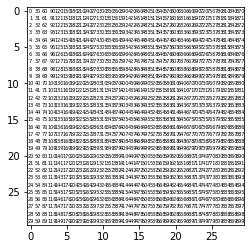

In [19]:
####### the ordering of the data pionts is off between Matlab and Python: Use this map as a 
# reference for acquisition numbers (index) relative to spatial mapping

fig, ax = plt.subplots()
pnts=np.arange(0,900)
pnts=pnts.reshape(30,30)

ax.imshow(pnts,cmap='magma',alpha=0.0)
for i in range(30):
    for j in range(30):
        text = ax.text(i, j, pnts[i, j],
                       ha="center", va="center", color="black",fontsize=5)
        
plt.savefig('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\Writing\\Small_Methods_Sub\\Revisions\\Pnts_ref_map.jpeg',dpi=300)

### Main Text FIGURE 1--last row

In [ ]:
#####Plot Average values for each Cycle ##### Main Text FIGURE 1--last row
fig=plt.figure(figsize=(12,3), dpi=100)
gs= gridspec.GridSpec(1, 5,height_ratios=[1], width_ratios = [1,1,1,1,1],hspace=0.0,wspace=0.5,top=0.9, bottom=0.2, left=0.05, right=0.92)

ax0=fig.add_subplot(gs[0,1])
df=write_1
var=df['Amp']
plot_var_ave(var,True)
plt.ylabel('On-F A'+" "+unit_dict['Amp'],fontsize=10, labelpad=3)
ax0.set_ylim([-0.5,7.0])
ax0.set_yticks([0,2,4,6])

ax1=fig.add_subplot(gs[0,3])
df=write_1
var=df['PR']
plot_var_ave(var,zero=False)
plt.ylabel('On-F PR'+" "+unit_dict['PR'],fontsize=10, labelpad=3)
ax1.set_ylim([-7.5,7.5])
ax1.set_yticks([-6.0,-3.0,0,3.0,6.0])


ax2=fig.add_subplot(gs[0,0])
df=read_1
var=df['Amp']
plot_var_ave(var,zero=True)
plt.ylabel('Off-F Amp'+" "+unit_dict['PR'],fontsize=10, labelpad=3)
ax2.set_ylim([-0.5,7.0])
ax2.set_yticks([0,2,4,6])

ax3=fig.add_subplot(gs[0,2])
df=read_1
var=df['PR']
plot_var_ave(var,zero=False)
plt.ylabel('Off-F PR'+" "+unit_dict['PR'],fontsize=10, labelpad=3)
ax3.set_ylim([-7.5,7.5])
ax3.set_yticks([-6.0,-3.0,0,3.0,6.0])


ax4= fig.add_subplot(gs[0,4])
df=read_1
var=df['Res']
plot_var_ave(var,zero=False)
plt.ylabel('Off-F $\omega$'+" "+unit_dict['Res'],fontsize=10, labelpad=3)
ax4.set_ylim([329.05,331.7])
ax4.set_yticks([329.5,330.0,330.5,331.0,331.5])
handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',frameon=False,handlelength=1.0)


### Used to make Noisy Write Res Supplementary Figure 10

In [ ]:
####Used to make Noisy Write Res Supplementary Figure 10

import random
#Generate 5 random numbers from write data
randomlist = random.sample(range(0, 900), 30)
print(randomlist)


fig=plt.figure(figsize=(6.0,5.0), dpi=100)
gs= gridspec.GridSpec(6, 5,height_ratios=[1,1,1,1,1,1], width_ratios = [1,1,1,1,1],
                      hspace=0.15,wspace=0.1,top=0.97, bottom=0.15, left=0.15, right=0.9)


for i,j in zip(randomlist[0:5],[0,1,2,3,4]):
    ax=fig.add_subplot(gs[0,j])
    plot_nan(write_nan,write_1,"Res",i,True,'black')
    plt.ylim(280,370)
    ax.set_yticks([290,325,360])
    plt.xlabel(" ")
    ax.set_xticklabels([])
    if j!=0:
        plt.ylabel(" ")
        ax.set_yticklabels([])
        
for i,j in zip(randomlist[5:10],[0,1,2,3,4]):
    ax=fig.add_subplot(gs[1,j])
    plot_nan(write_nan,write_1,"Res",465,True,'black')
    plt.ylim(280,370)
    ax.set_yticks([290,325,360])
    plt.xlabel(" ")
    ax.set_xticklabels([])
    if j!=0:
        plt.ylabel(" ")
        ax.set_yticklabels([])
        
for i,j in zip(randomlist[10:15],[0,1,2,3,4]):
    ax=fig.add_subplot(gs[2,j])
    plot_nan(write_nan,write_1,"Res",i,True,'black')
    plt.ylim(280,370)
    ax.set_yticks([290,325,360])
    plt.xlabel(" ")
    ax.set_xticklabels([])
    if j!=0:
        plt.ylabel(" ")
        ax.set_yticklabels([])
for i,j in zip(randomlist[15:20],[0,1,2,3,4]):
    ax=fig.add_subplot(gs[3,j])
    plot_nan(write_nan,write_1,"Res",i,True,'black')
    plt.ylim(280,370)
    ax.set_yticks([290,325,360])
    plt.xlabel(" ")
    ax.set_xticklabels([])
    if j!=0:
        plt.ylabel(" ")
        ax.set_yticklabels([])
        
for i,j in zip(randomlist[20:25],[0,1,2,3,4]):
    ax=fig.add_subplot(gs[4,j])
    plot_nan(write_nan,write_1,"Res",i,True,'black')
    plt.ylim(280,370)
    ax.set_yticks([290,325,360])
    plt.xlabel(" ")
    ax.set_xticklabels([])
    if j!=0:
        plt.ylabel(" ")
        ax.set_yticklabels([])
        
for i,j in zip(randomlist[25:],[0,1,2,3,4]):
    ax=fig.add_subplot(gs[5,j])
    plot_nan(write_nan,write_1,"Res",i,True,'black')
    plt.ylim(280,370)
    ax.set_yticks([290,325,360])
    if j!=0:
        plt.ylabel(" ")
        ax.set_yticklabels([])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,loc=((0.25,0.01)),ncol=4, fontsize=9,frameon=False,handletextpad=0.25,framealpha=0.1,markerscale=1,handlelength=1)

### Suplementary Figure 14

In [ ]:
####Used to make Respresentative Piont responses from N1, N2, N3 DL component (pnt 50, 23, 228 repectively) #####Suplementary Figure 14
df1=read_1
df_nan1=read_nan
df2=write_1
df_nan2=write_nan
pnt=228
Ec=np.nan
Ec_=np.nan
label=np.nan
nan_all(df1,df_nan1,df2,df_nan2,pnt,Ec,Ec_,label)

### Supplementary Figure 16

In [ ]:
######Super Position of Piont 391 read (ferroelectric) response with Point 50 Write (electrostatic-ish) response 
##to make Supplementary Figure 16. Final Image generated in GIMP######
write_1_=write_1*0.5
write_nan_=write_nan

r_scale=0.1
w_scale=1-r_scale #### Scaling factors for linear combination of reponses
w_scale= round(w_scale, 2)

w=w_scale*write_1_['PR'].iloc[50:51,:].values[0]        #non-ferroelectric component (c1 in Sup Figure XX)
r=r_scale*read_1['PR'].iloc[391:392,:].values[0]        #ferroelectric component  (c2 in Sup Figure XX)

mixed=pd.DataFrame(r+w)
mixed=pd.DataFrame(mixed.transpose().values,columns=read_1["Amp"].columns)  ####Linear addition of C1 and C2



fig= plt.figure(figsize=(6.0,3.0), dpi=100)
gs= gridspec.GridSpec(1, 3,height_ratios=[1], width_ratios = [1,1,1],
                      hspace=0.1,wspace=0.05,top=0.97, bottom=0.15, left=0.1, right=0.9)



ax_w=fig.add_subplot(gs[0,0])                              # plot non-ferroelectric component (c1 in Sup Figure XX)
plot_nan(write_nan_,write_1_,"PR",50,True,'black')
handles, labels = ax_w.get_legend_handles_labels()
ax_w.set_ylim([-7.0,7])
ax_w.set_yticks([-5,0,5])
ax_w.annotate('$C_1$',(0.08,0.92),xycoords='axes fraction',fontweight='normal',color="black")

ax_r=fig.add_subplot(gs[0,1])                          # plot ferroelectric component (c2 in Sup Figure XX)
plot_nan(read_nan,read_1,"PR",391,True,'black')
handles, labels = ax_r.get_legend_handles_labels()
ax_r.set_ylabel(" ")
ax_r.set_ylim([-7,7])
#ax_r.set_yticks([-5,0,5])
ax_r.set_yticklabels([])
ax_r.annotate("$C_2$",(0.08,0.92),xycoords='axes fraction',fontweight='normal',color="black")


ax=fig.add_subplot(gs[0,2])         # plot linear addition
x0 = dc[4:]
x = dc
c1='black'
    
y1 = 1*mixed[0].values[0].copy()######Cycle 1
y2 =1* mixed[1].values[0].copy()####Cycle 2
y3 =1* mixed[2].values[0].copy()####Cycle 3

plt.plot(x0,y1,color='black',linestyle='-',label='Cycle 1')
plt.plot(x,y2,color='black',linestyle=':',label='Cycle 2')
plt.plot(x,y3,color='black',linestyle='--',label='Cycle 3')
ax.set_xlabel("Bias (V)")
ax.yaxis.set_label_position("left")
ax.set_ylim([-7.0,7])
ax.set_yticks([-5,0,5])
ax.set_yticklabels([])
ax.set_ylabel(" ")
ax.annotate("$C_1$ {} \n$C_2$ {} ".format(w_scale,r_scale),(0.05,0.84),xycoords='axes fraction',fontweight='normal',color="black")
ax.set_xticks([-10,-5,0,5,10])

fig.legend(handles, labels,loc=(0.10,0.15),ncol=1, fontsize=9,frameon=False,handletextpad=0.25,framealpha=0.1,markerscale=1,handlelength=1)